# Kaggle Galaxy Competition

In [1]:
%matplotlib inline

path = "data/galaxy/sample/"
#path = "data/galaxy/"

train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
results_path = path + 'results/'

In [2]:
from utils import *

Using Theano backend.


In [3]:
batch_size = 4
num_epoch = 1

In [4]:
import pandas as pd
df = pd.read_csv(path+ "train.csv")
df.head()

,Unnamed: 0,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,36884,639130,0.698353,0.251825,0.049822,0.083858,0.167967,0.0,0.167967,0.133755,...,0.000000,0.000000,0.000000,0.133755,0.133755,0.0,0.0,0.0,0.0,0.000000
1,26894,493335,0.322609,0.676716,0.000675,0.676716,0.000000,0.0,0.000000,0.000000,...,0.607389,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,54324,892904,0.882000,0.118000,0.000000,0.019706,0.098294,0.0,0.098294,0.019659,...,0.000000,0.019659,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.019659
3,31199,557882,0.452953,0.547047,0.000000,0.088929,0.458118,0.0,0.458118,0.056136,...,0.000000,0.000000,0.056136,0.000000,0.000000,0.0,0.0,0.0,0.0,0.056136
4,60176,979374,0.731288,0.268712,0.000000,0.000000,0.268712,0.0,0.268712,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [33]:
import Iterator; reload(Iterator)
from Iterator import DirectoryIterator

imgen = image.ImageDataGenerator()
batches = DirectoryIterator(train_path, imgen, 
                            class_mode=None, 
                            dataframe=df,
                            batch_size=4)

Found 200 images belonging to 1 classes.


In [34]:
imgs, target = next(batches)
imgs[0].shape

(3, 256, 256)

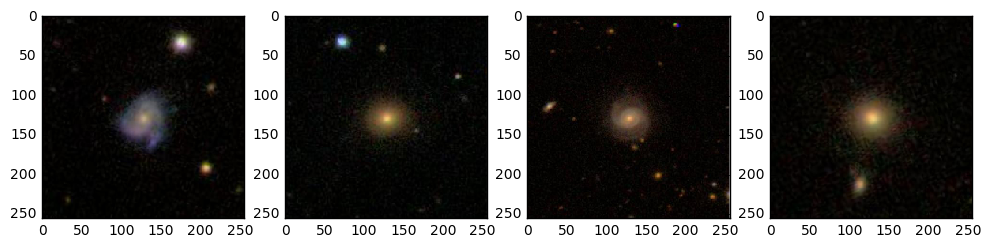

In [35]:
plots(imgs)

In [36]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [37]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [38]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [39]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [43]:
def galaxy():
    model = Sequential()
    model.add(Lambda(vgg_preprocess,input_shape=(3,256,256)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(37))
    
    model.compile(optimizer='Adam', loss='mse')
    return model

In [44]:
model = galaxy()

/home/ubuntu/anaconda2/envs/fastai/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 256, 256)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [ ]:
model.fit_generator(batches, samples_per_epoch=200, nb_epoch=5)

Epoch 1/5
 28/200 [===>..........................] - ETA: 354s - loss: 0.0685

In [ ]:
df_val = pd.read_csv(path+ "valid.csv")

imgen = image.ImageDataGenerator()
val_batches = DirectoryIterator(valid_path, imgen, 
                            class_mode=None, 
                            dataframe=df_val,
                            batch_size=4)

In [ ]:
imgs, targets = next(val_batches)

In [ ]:
model.evaluate_generator(val_batches, 50)